# 1. Load Dataset and Initial Exploration

Load the dataset and perform basic checks:
- Shape of the data
- Data types and missing values
- Preview first few rows
- Summary statistics
- Missing value counts



In [2]:
import pandas as pd

df = pd.read_csv('../data/raw/airbnb_raw.csv')  

# Print the shape of the dataset
print(df.shape)

# Display info about data types and non-null counts
print(df.info())

# Preview the first five rows
print(df.head())

# Show summary statistics for numeric columns
print(df.describe())

# Count missing values per column
print(df.isnull().sum())


C:\Users\janak\AppData\Local\Temp\ipykernel_2472\2219472005.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/airbnb_raw.csv')


(102599, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102598 non-null  float64
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  can

# 2. Clean Column Names, Fix Price Columns, Remove Duplicates, and Analyze Correlations with Price

- Standardize column names (lowercase, replace spaces).
- Remove dollar signs and convert price-related columns to numeric.
- Drop duplicate rows.
- Calculate correlations of numeric features with price.
- Identify which features have strong relationships with price.


In [3]:
import numpy as np

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Clean 'price' and 'service_fee' columns
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)
df['service_fee'] = df['service_fee'].str.replace('$', '').str.replace(',', '').astype(float)

# Drop duplicates
df = df.drop_duplicates()

# Show number of rows after dropping duplicates
print(f"Rows after dropping duplicates: {df.shape[0]}")

# Select numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation with price
correlations = df[numeric_cols].corr()['price'].sort_values(ascending=False)

print("Correlation of numeric features with price:")
print(correlations)

# Optionally: show only correlations with absolute value above a threshold, e.g., 0.1
strong_corr = correlations[correlations.abs() > 0.1]
print("\nStrong correlations (|corr| > 0.1):")
print(strong_corr)


Rows after dropping duplicates: 102060
Correlation of numeric features with price:
price                             1.000000
service_fee                       0.999991
number_of_reviews                 0.005073
id                                0.004476
reviews_per_month                 0.004023
host_id                           0.003624
long                              0.003338
calculated_host_listings_count   -0.000101
availability_365                 -0.002771
minimum_nights                   -0.003290
construction_year                -0.003716
review_rate_number               -0.004642
lat                              -0.005567
Name: price, dtype: float64

Strong correlations (|corr| > 0.1):
price          1.000000
service_fee    0.999991
Name: price, dtype: float64


# 3 Drop Redundant Feature

- Drop `service_fee` due to extremely high correlation with `price`, indicating redundancy and potential leakage.
- Prepare for visual EDA to explore relationships between categorical features and price.


In [4]:
# Drop service_fee to avoid redundancy and leakage
df = df.drop(columns=['service_fee'])

print("Remaining columns after dropping service_fee:")
print(df.columns.tolist())


Remaining columns after dropping service_fee:
['id', 'name', 'host_id', 'host_identity_verified', 'host_name', 'neighbourhood_group', 'neighbourhood', 'lat', 'long', 'country', 'country_code', 'instant_bookable', 'cancellation_policy', 'room_type', 'construction_year', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'house_rules', 'license']


# 4. Exploratory Data Analysis (EDA): Categorical Features vs. Price

Focus on categorical variables that may influence price:

- `room_type`
- `neighbourhood_group`
- `cancellation_policy`
- `instant_bookable`
- `host_identity_verified`

Visualize these with boxplots to spot differences in price distributions.


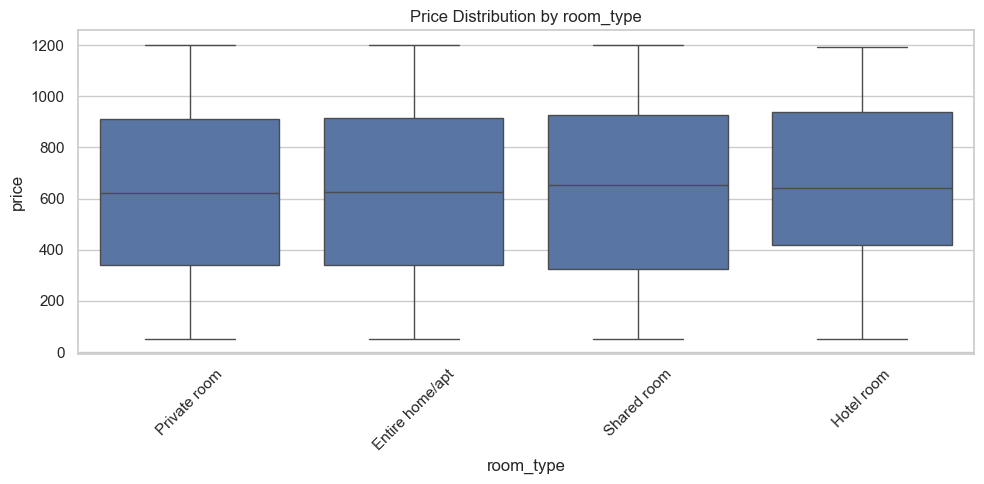

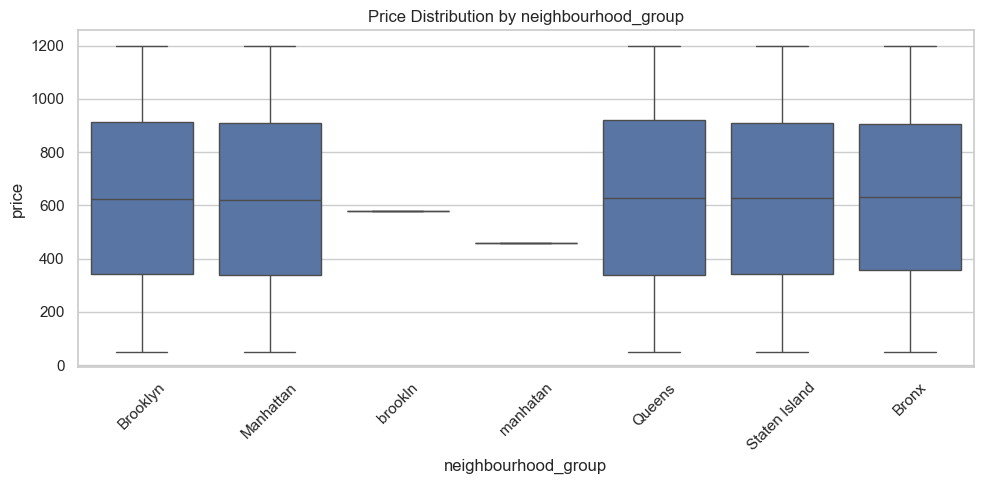

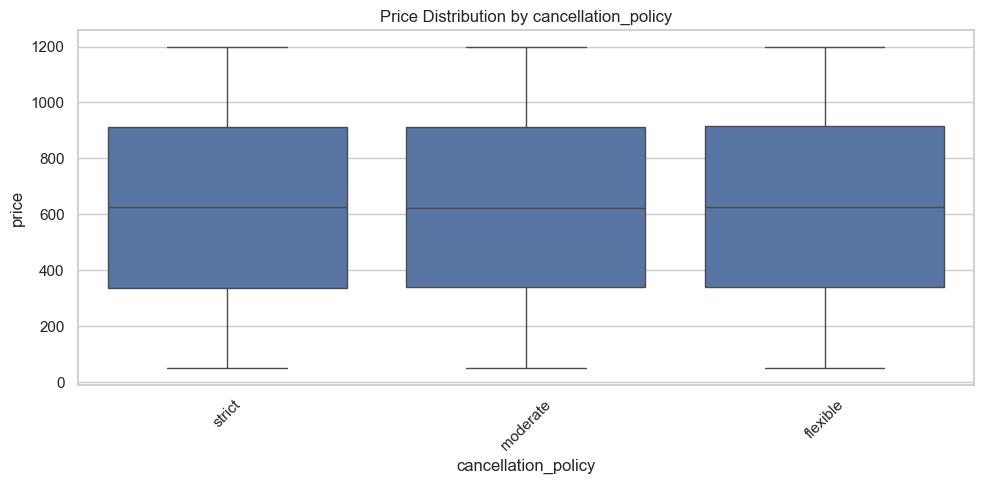

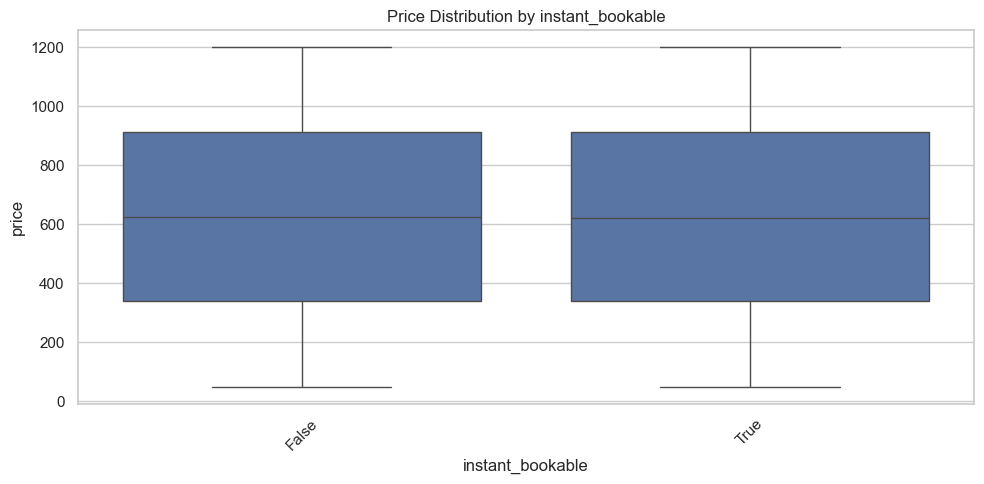

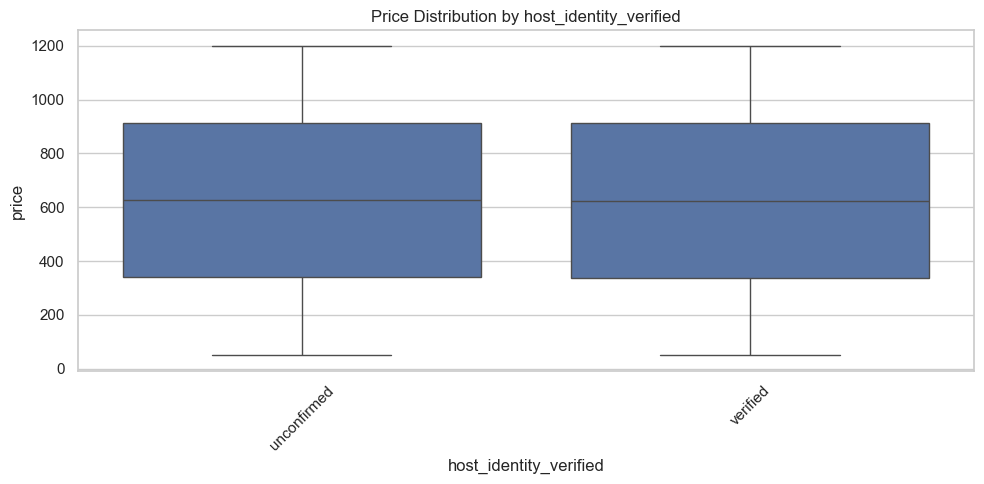

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

# Define list of categorical features to plot against price
cat_features = [
    'room_type',
    'neighbourhood_group',
    'cancellation_policy',
    'instant_bookable',
    'host_identity_verified'
]

# Create boxplots for each categorical feature vs. price
for feature in cat_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=feature, y='price')
    plt.title(f'Price Distribution by {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# 5. Data Cleaning: Drop Irrelevant Columns and Remove Invalid or Missing Data

- Drop irrelevant columns: `id`, `name`, `host_id`, `host_name`, `country`, `country_code`, `calculated_host_listings_count`, `house_rules`, `license`.
- Drop rows with missing values in the remaining columns to ensure clean data for analysis.
- Remove rows with invalid values in columns that must be within logical ranges (e.g., no negative or impossible values in `availability_365`, `review_rate_number`, `minimum_nights`).
- Reason: Since no single column strongly predicts price, we focus on cleaning data first before combining features for deeper insights.


In [11]:
# Drop irrelevant columns
cols_to_drop = [
    'id', 'name', 'host_id', 'host_name',
    'country', 'country_code',
    'calculated_host_listings_count',
    'house_rules', 'license'
]
df = df.drop(columns=cols_to_drop)

# Drop rows with any missing values in remaining columns
df = df.dropna()

# Remove invalid values based on logical constraints
df = df[
    (df['availability_365'] >= 0) & (df['availability_365'] <= 365) &
    (df['review_rate_number'] >= 1) & (df['review_rate_number'] <= 5) &
    (df['minimum_nights'] > 0) &
    (df['price'] > 0)
]

# Confirm shape after cleaning
print(f"Shape after dropping irrelevant columns, missing and invalid values: {df.shape}")


Shape after dropping irrelevant columns, missing and invalid values: (82216, 16)


# 6. Correlation Analysis: Price vs Remaining Features

- After cleaning, we check how remaining numeric features correlate with price.
- Use correlation matrix and visualize with a heatmap for clarity.
- This helps to identify which features might impact price the most.


Correlation of features with price:
price                 1.000000
number_of_reviews     0.005204
reviews_per_month     0.004232
availability_365      0.001349
long                  0.000507
minimum_nights       -0.003526
construction_year    -0.005373
lat                  -0.005797
review_rate_number   -0.008424
Name: price, dtype: float64


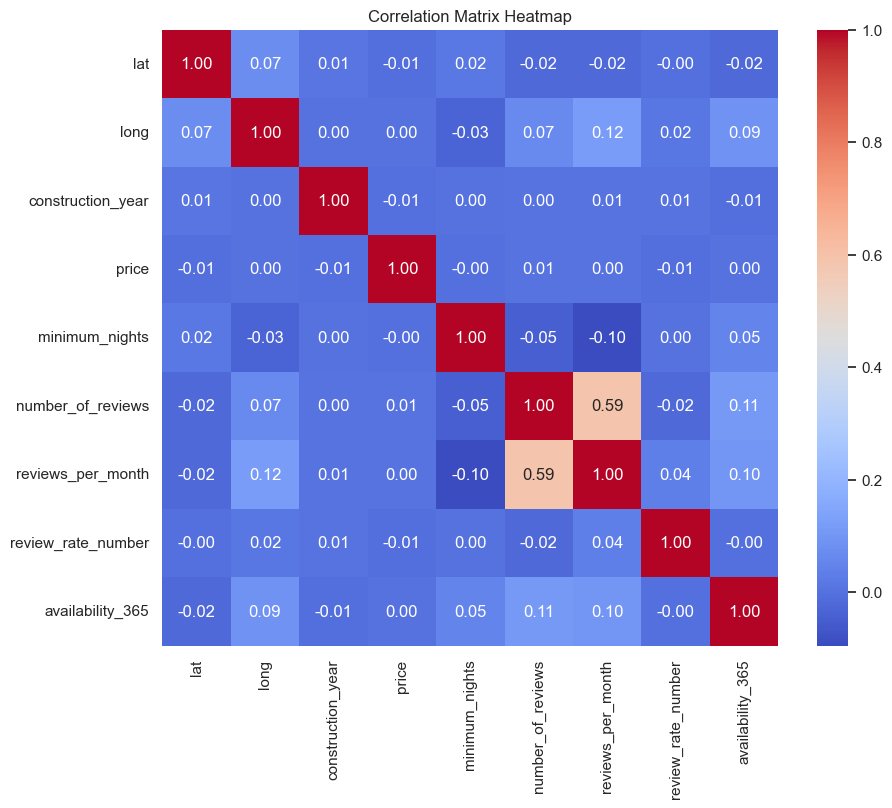

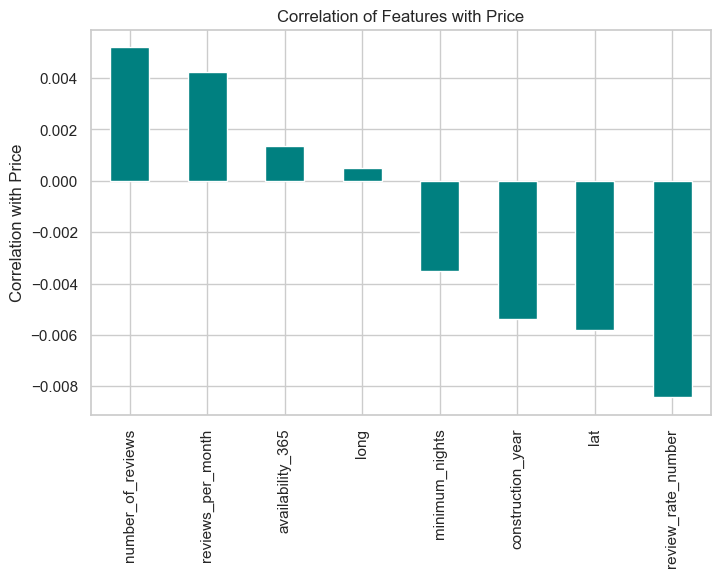

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Extract correlation of all features with price
price_corr = corr_matrix['price'].sort_values(ascending=False)

print("Correlation of features with price:")
print(price_corr)

# Visualize correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Visualize only correlation of features with price as bar plot
plt.figure(figsize=(8, 5))
price_corr.drop('price').plot(kind='bar', color='teal')
plt.ylabel('Correlation with Price')
plt.title('Correlation of Features with Price')
plt.show()


# 7. Visualize Price Distribution by Categorical Features

Since correlation doesn't work with categorical data, use boxplots to check how `neighbourhood_group` and `room_type` affect price.



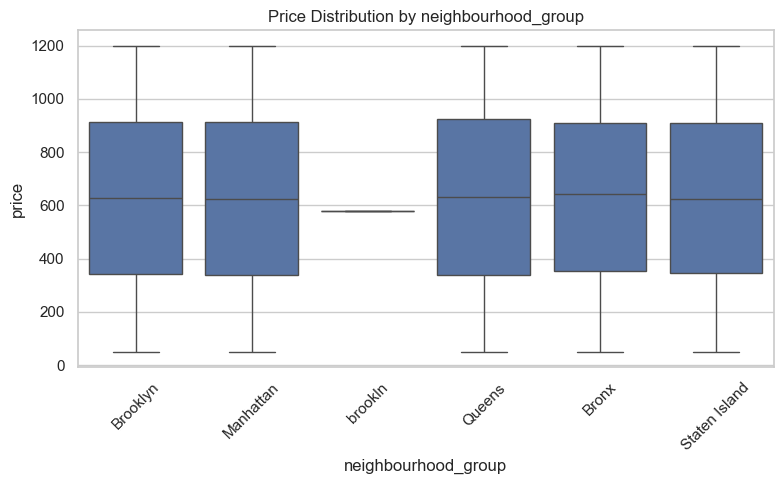

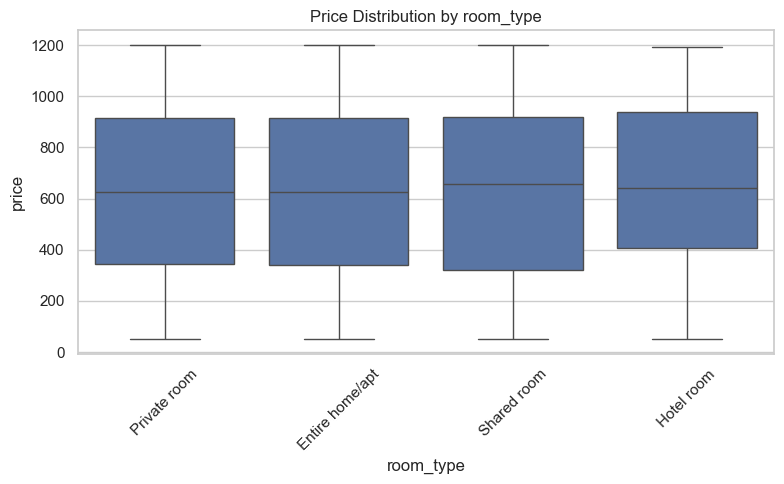

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_features = ['neighbourhood_group', 'room_type']

for feature in cat_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=feature, y='price')
    plt.title(f'Price Distribution by {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# 8. Check Unique Values in Remaining Features

- Inspect unique values in categorical columns to spot inconsistencies, typos, or rare categories.
- Decide if any manual cleaning or grouping is needed before modeling.


In [14]:
# List of remaining columns after previous drops (you can adjust this list if needed)
remaining_cols = df.columns.tolist()

# For categorical columns, check unique values
for col in remaining_cols:
    if df[col].dtype == 'object':
        unique_vals = df[col].unique()
        print(f"Column: {col} - Unique values ({len(unique_vals)}): {unique_vals}\n")


Column: host_identity_verified - Unique values (2): ['unconfirmed' 'verified']

Column: neighbourhood_group - Unique values (6): ['Brooklyn' 'Manhattan' 'brookln' 'Queens' 'Bronx' 'Staten Island']

Column: neighbourhood - Unique values (223): ['Kensington' 'Midtown' 'Clinton Hill' 'East Harlem' 'Bedford-Stuyvesant'
 "Hell's Kitchen" 'Chinatown' 'Upper West Side' 'South Slope'
 'West Village' 'Bushwick' 'East Village' 'Williamsburg' 'Harlem'
 'Prospect-Lefferts Gardens' 'Washington Heights' 'Greenpoint'
 'Lower East Side' 'Flatlands' 'Fort Greene' 'Prospect Heights'
 'Financial District' 'Ridgewood' 'Park Slope' 'Flatiron District'
 'Windsor Terrace' 'Roosevelt Island' 'SoHo' 'Greenwich Village' 'Chelsea'
 'Carroll Gardens' 'Kingsbridge' 'Astoria' 'Boerum Hill' 'Gowanus'
 'Rockaway Beach' 'Crown Heights' 'Upper East Side' 'Brooklyn Heights'
 'Woodlawn' 'Gramercy' 'East New York' 'Sunnyside' 'Concourse Village'
 'Theater District' 'Emerson Hill' 'Long Island City' 'Fort Hamilton'
 'Conco

# 9. Fix Typos in Categorical Features

- Correct typo in `neighbourhood_group`: replace "brookln" with "Brooklyn"
- Leave other categories unchanged for now


In [15]:
# Fix typo in neighbourhood_group
df['neighbourhood_group'] = df['neighbourhood_group'].replace('brookln', 'Brooklyn')

# Confirm fix
print(df['neighbourhood_group'].unique())


['Brooklyn' 'Manhattan' 'Queens' 'Bronx' 'Staten Island']


# 10. Analyze Price Impact by Neighbourhood

- Calculate average price per neighbourhood.
- Sort to find most and least expensive neighborhoods.
- Visualize the top 20 neighborhoods by average price.


Top 10 most expensive neighbourhoods by average price:
neighbourhood
New Dorp                  1048.000000
Chelsea, Staten Island    1042.000000
Little Neck                906.333333
New Dorp Beach             849.500000
Riverdale                  822.416667
Arden Heights              804.888889
Jamaica Hills              800.250000
Midland Beach              792.666667
East Morrisania            778.947368
Shore Acres                777.916667
Name: price, dtype: float64

Top 10 cheapest neighbourhoods by average price:
neighbourhood
Marble Hill                   438.842105
Bay Terrace, Staten Island    429.500000
Prince's Bay                  396.200000
Richmondtown                  373.400000
Breezy Point                  368.000000
Spuyten Duyvil                314.125000
Castle Hill                   308.000000
Rossville                     300.666667
Lighthouse Hill               107.666667
Woodrow                        78.000000
Name: price, dtype: float64


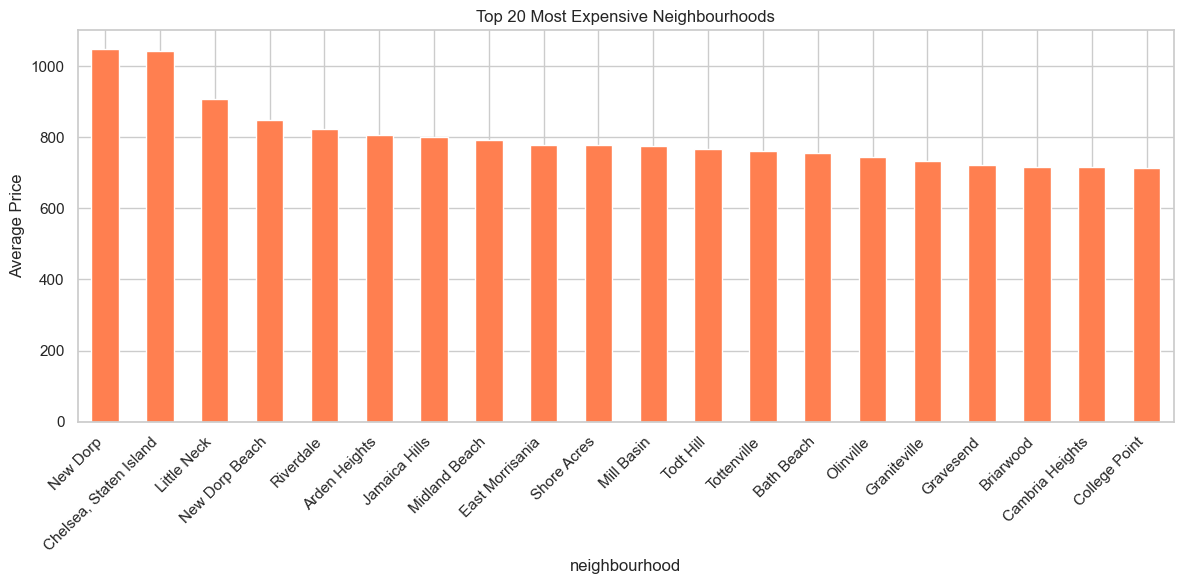

In [16]:
import matplotlib.pyplot as plt

# Calculate average price by neighbourhood
neighbourhood_price = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

# Show top 10 most expensive neighborhoods
print("Top 10 most expensive neighbourhoods by average price:")
print(neighbourhood_price.head(10))

# Show top 10 cheapest neighborhoods
print("\nTop 10 cheapest neighbourhoods by average price:")
print(neighbourhood_price.tail(10))

# Visualize top 20 neighborhoods by average price
plt.figure(figsize=(12,6))
neighbourhood_price.head(20).plot(kind='bar', color='coral')
plt.ylabel('Average Price')
plt.title('Top 20 Most Expensive Neighbourhoods')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 11. Analyze Neighborhoods by Price and Number of Listings

- Calculate average price and count of listings per neighborhood.
- Display top 30 most expensive and cheapest neighborhoods with listing counts.


In [17]:
# Calculate avg price and listing count per neighborhood
neigh_stats = df.groupby('neighbourhood').agg(
    avg_price = ('price', 'mean'),
    listings_count = ('price', 'count')
).sort_values(by='avg_price', ascending=False)

# Top 30 most expensive neighborhoods
print("Top 30 most expensive neighborhoods:")
print(neigh_stats.head(30))

# Top 30 cheapest neighborhoods
print("\nTop 30 cheapest neighborhoods:")
print(neigh_stats.tail(30))


Top 30 most expensive neighborhoods:
                          avg_price  listings_count
neighbourhood                                      
New Dorp                1048.000000               1
Chelsea, Staten Island  1042.000000               1
Little Neck              906.333333               6
New Dorp Beach           849.500000               6
Riverdale                822.416667              12
Arden Heights            804.888889               9
Jamaica Hills            800.250000              20
Midland Beach            792.666667              15
East Morrisania          778.947368              19
Shore Acres              777.916667              12
Mill Basin               775.142857              14
Todt Hill                768.166667               6
Tottenville              761.900000              10
Bath Beach               756.818182              44
Olinville                743.176471              17
Graniteville             732.571429               7
Gravesend                72

### Visualizing Neighbourhood Impact on Price and Listings

To better understand how different neighbourhoods affect the price and number of listings, let's visualize the average price and listing count for the top 30 neighbourhoods. This graphical representation will confirm the observations from the numeric summary and help us make informed decisions on feature selection.


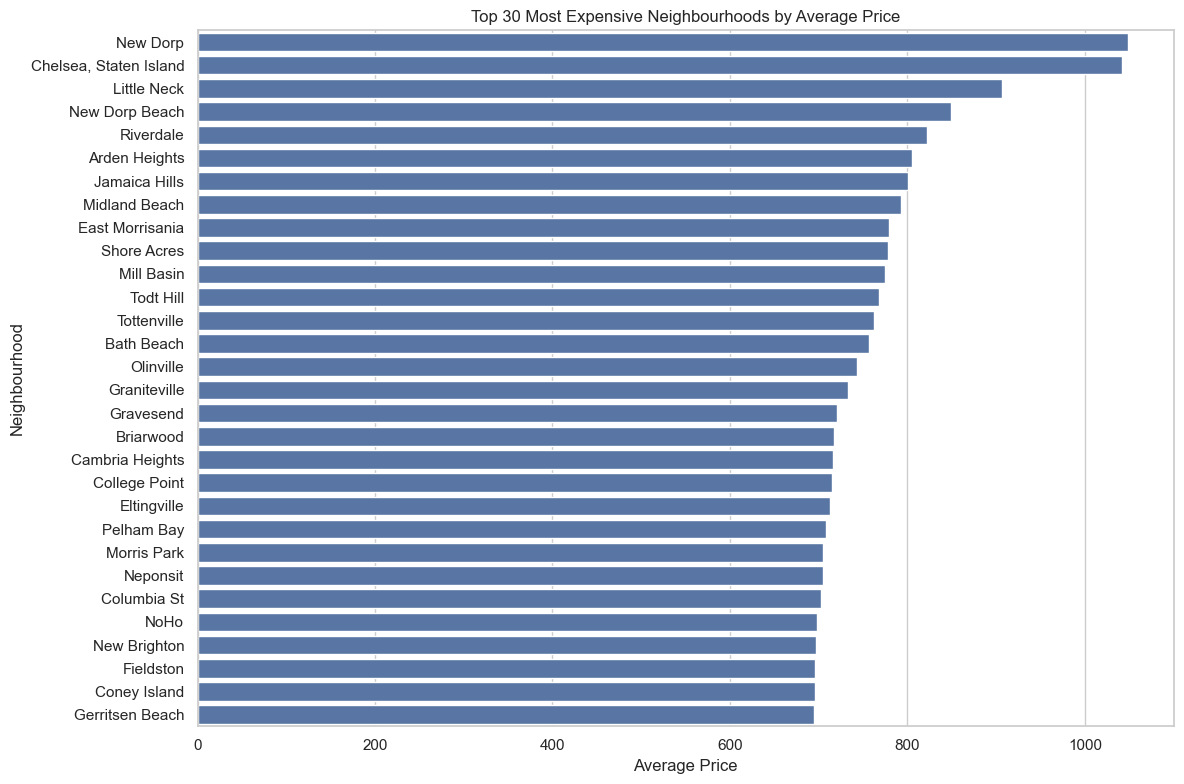

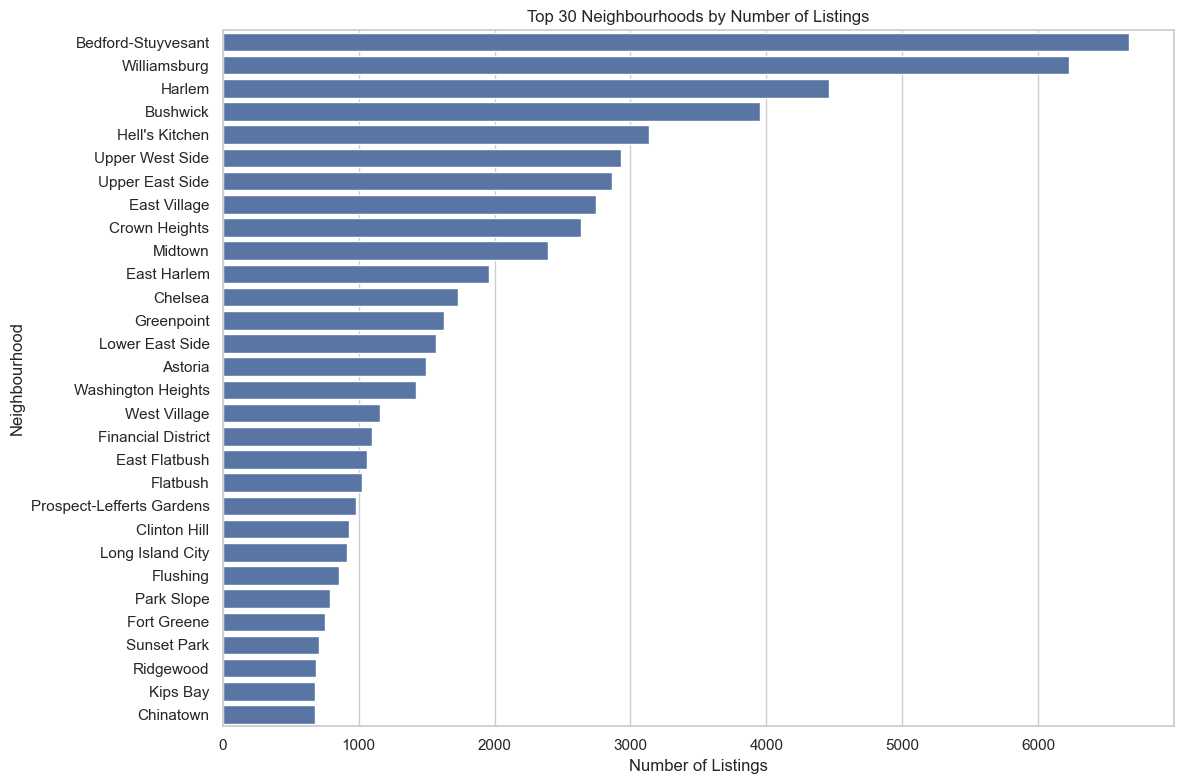

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary of neighborhood avg price and listings count
neigh_summary = df.groupby('neighbourhood').agg(
    avg_price=('price', 'mean'),
    listings_count=('price', 'count')
).sort_values(by='avg_price', ascending=False)

# Plot top 30 neighbourhoods by average price
plt.figure(figsize=(12, 8))
sns.barplot(x=neigh_summary.head(30)['avg_price'], y=neigh_summary.head(30).index)
plt.title('Top 30 Most Expensive Neighbourhoods by Average Price')
plt.xlabel('Average Price')
plt.ylabel('Neighbourhood')
plt.tight_layout()
plt.show()

# Plot top 30 neighbourhoods by listings count
plt.figure(figsize=(12, 8))
top_listings = neigh_summary.sort_values(by='listings_count', ascending=False).head(30)
sns.barplot(x=top_listings['listings_count'], y=top_listings.index)
plt.title('Top 30 Neighbourhoods by Number of Listings')
plt.xlabel('Number of Listings')
plt.ylabel('Neighbourhood')
plt.tight_layout()
plt.show()


### Next Steps for Model Building

Based on the clear impact of neighbourhood on price shown by the EDA, we will use **neighbourhood** as the central feature in our price prediction model. Alongside, we will include the top other features that show influence on price such as room type, review-related metrics, construction year, minimum nights, and instant bookable status to improve the model's predictive power.


In [24]:
# Show all column names with missing value counts (including zero)
missing_values_all = df.isna().sum()
print(missing_values_all)


host_identity_verified    0
neighbourhood_group       0
neighbourhood             0
lat                       0
long                      0
instant_bookable          0
cancellation_policy       0
room_type                 0
construction_year         0
price                     0
minimum_nights            0
number_of_reviews         0
last_review               0
reviews_per_month         0
review_rate_number        0
availability_365          0
dtype: int64


In [25]:
# Get basic statistics: min, max, and mean for all numerical columns
stats = df.describe().loc[['min', 'max', 'mean']].transpose()
print(stats)


                           min         max         mean
lat                   40.50456    40.91697    40.727306
long                 -74.24984   -73.70522   -73.948226
construction_year   2003.00000  2022.00000  2012.492824
price                 50.00000  1200.00000   626.708171
minimum_nights         1.00000  5645.00000     7.449584
number_of_reviews      1.00000  1024.00000    31.910954
reviews_per_month      0.01000    90.00000     1.390198
review_rate_number     1.00000     5.00000     3.288192
availability_365       0.00000   365.00000   135.540771


### Removing Outliers
We will remove outliers from the following columns using the IQR method:

- `minimum_nights`
- `number_of_reviews`
- `reviews_per_month`
- `review_rate_number`

This ensures that extreme values do not distort our model performance.


In [26]:
# Define columns to clean
outlier_cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number']

# Apply IQR method
for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Shape after removing outliers
print("Data shape after outlier removal:", df.shape)


Data shape after outlier removal: (59732, 16)


### Analyzing `availability_365`
We'll check the distribution, summary statistics, and possible anomalies in the `availability_365` column to decide if further cleaning is needed.


Summary statistics for availability_365:
count    59732.000000
mean       123.788154
std        127.928841
min          0.000000
25%          0.000000
50%         79.000000
75%        233.000000
max        365.000000
Name: availability_365, dtype: float64

Unique values (sorted):
[np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0)] ... [np.float64(356.0), np.float64(357.0), np.float64(358.0), np.float64(359.0), np.float64(360.0), np.float64(361.0), np.float64(362.0), np.float64(363.0), np.float64(364.0), np.float64(365.0)]


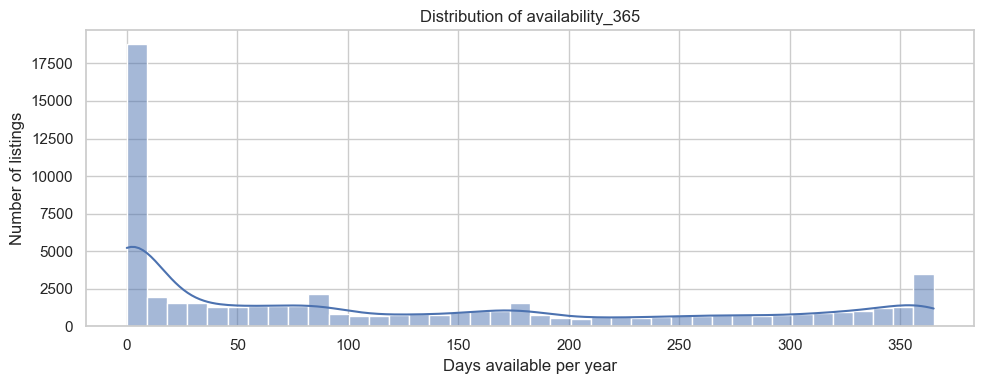

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print("Summary statistics for availability_365:")
print(df['availability_365'].describe())

# Check for unusual values
print("\nUnique values (sorted):")
print(sorted(df['availability_365'].unique())[:10], '...', sorted(df['availability_365'].unique())[-10:])

# Plot distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['availability_365'], bins=40, kde=True)
plt.title("Distribution of availability_365")
plt.xlabel("Days available per year")
plt.ylabel("Number of listings")
plt.tight_layout()
plt.show()


### Removing listings with `availability_365 = 0`
Listings with 0 days available in a year are not useful for our price prediction model. We will drop these rows to keep only active listings.


In [29]:
# Remove rows where availability_365 is 0
df = df[df['availability_365'] > 0]

# Confirm removal
print("Remaining rows after removing availability_365 = 0:", len(df))


Remaining rows after removing availability_365 = 0: 44295


### Dropping `lat` and `long`
Since `lat` and `long` have very weak correlation with price and we are already using `neighbourhood` as a key location feature, we will drop them.


In [30]:
# Drop latitude and longitude
df.drop(['lat', 'long'], axis=1, inplace=True)

# Confirm remaining columns
print("Remaining columns:\n", df.columns)


Remaining columns:
 Index(['host_identity_verified', 'neighbourhood_group', 'neighbourhood',
       'instant_bookable', 'cancellation_policy', 'room_type',
       'construction_year', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'review_rate_number',
       'availability_365'],
      dtype='object')


### Dropping `neighbourhood_group`
Since we already have more detailed information in the `neighbourhood` column and `neighbourhood_group` is just a higher-level aggregation, we will drop it to avoid redundancy.


In [31]:
# Drop the neighbourhood_group column
df.drop('neighbourhood_group', axis=1, inplace=True)

# Check remaining columns
print("Remaining columns:\n", df.columns)


Remaining columns:
 Index(['host_identity_verified', 'neighbourhood', 'instant_bookable',
       'cancellation_policy', 'room_type', 'construction_year', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'review_rate_number', 'availability_365'],
      dtype='object')


In [32]:
# Display basic info about the remaining columns
print(df.info())

# Check summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
print(df.describe())

# Check unique values for categorical columns to assess if cleaning is needed
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())


<class 'pandas.core.frame.DataFrame'>
Index: 44295 entries, 11 to 102597
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_identity_verified  44295 non-null  object 
 1   neighbourhood           44295 non-null  object 
 2   instant_bookable        44295 non-null  object 
 3   cancellation_policy     44295 non-null  object 
 4   room_type               44295 non-null  object 
 5   construction_year       44295 non-null  float64
 6   price                   44295 non-null  float64
 7   minimum_nights          44295 non-null  float64
 8   number_of_reviews       44295 non-null  float64
 9   last_review             44295 non-null  object 
 10  reviews_per_month       44295 non-null  float64
 11  review_rate_number      44295 non-null  float64
 12  availability_365        44295 non-null  float64
dtypes: float64(7), object(6)
memory usage: 4.7+ MB
None

Summary statistics for numeric columns:
 

### Final correlation check of remaining features with price

We will analyze numeric columns with correlation coefficients, and visualize categorical columns using boxplots to understand how price varies across categories. This will help us confirm which features have meaningful relationships with price before preparing data for modeling.


Correlation of numeric features with price:
price                 1.000000
reviews_per_month     0.002775
availability_365      0.002556
number_of_reviews     0.001874
minimum_nights       -0.000852
construction_year    -0.002187
review_rate_number   -0.013412
Name: price, dtype: float64


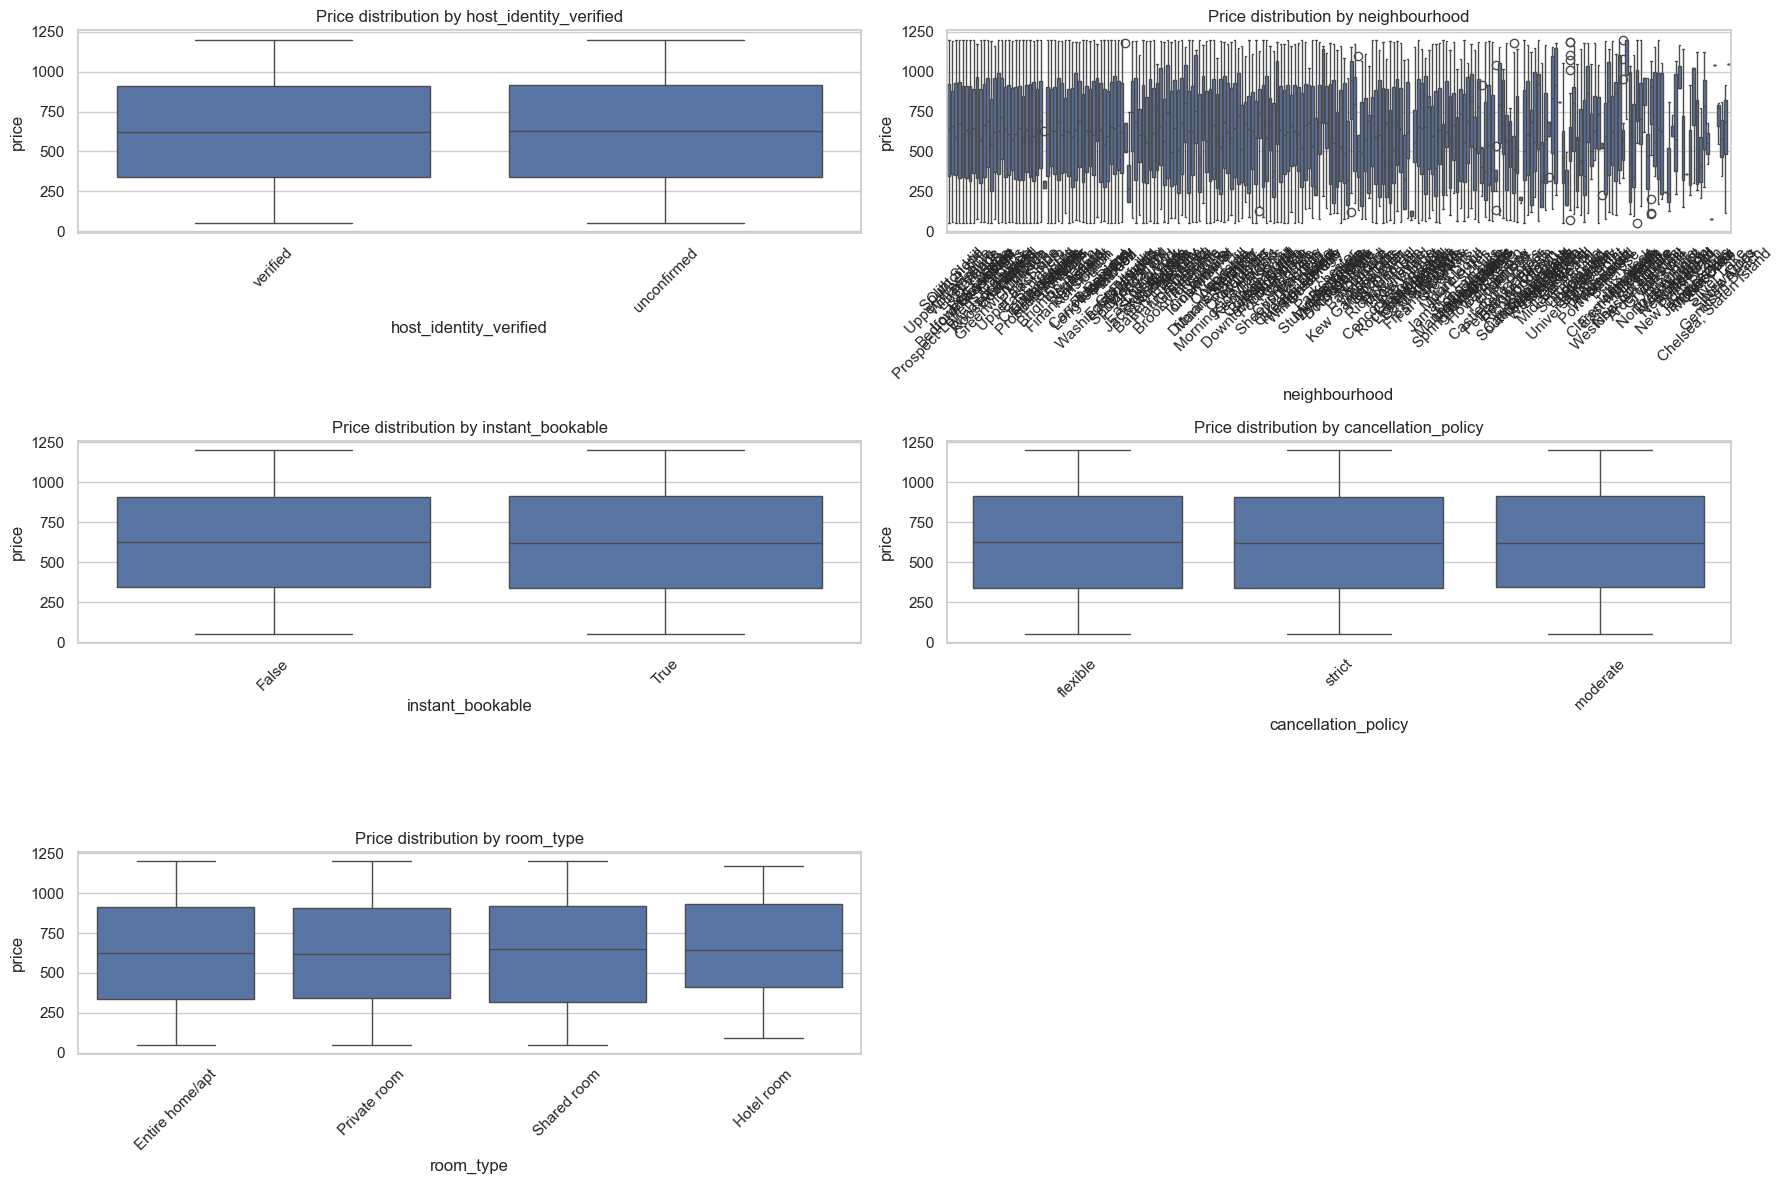

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numeric columns to correlate with price (exclude 'price' itself)
numeric_cols = ['construction_year', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'availability_365']

print("Correlation of numeric features with price:")
print(df[numeric_cols + ['price']].corr()['price'].sort_values(ascending=False))

# Plot categorical features price distribution
categorical_cols = ['host_identity_verified', 'neighbourhood', 'instant_bookable', 'cancellation_policy', 'room_type']

plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=col, y='price', data=df)
    plt.title(f'Price distribution by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


### 🧠 Target Encoding `neighbourhood` by Average Price

During EDA, we observed that `neighbourhood` had a strong influence on `price`, while other features had weaker effects.  
To simplify and strengthen our model, we are grouping `neighbourhood` values by their average price using target encoding.

We will use a tree-based model (like Random Forest) that will take `neighbourhood_encoded` as the main signal and learn how other features influence pricing **within each location's average range**.

This avoids one-hot encoding explosion and helps the model focus on patterns that matter.


In [4]:
import pandas as pd
import os
import joblib

# Load the dataset
df = pd.read_csv("../data/cleaned/airbnb_cleaned.csv")

# Step 1: Compute average price per neighbourhood
neigh_price_mean = df.groupby('neighbourhood')['price'].mean()

# Step 2: Create new column with encoded neighbourhood prices
df['neighbourhood_encoded'] = df['neighbourhood'].map(neigh_price_mean)

# Step 3: Save the encoding mapping for future use (in Streamlit app)
os.makedirs("models", exist_ok=True)
joblib.dump(neigh_price_mean, "models/neighbourhood_encoding.pkl")

# Optional: Drop the original neighbourhood column if you don't need it anymore
df.drop('neighbourhood', axis=1, inplace=True)

# Show first few rows to verify
df[['neighbourhood_encoded', 'price']].head()


,neighbourhood_encoded,price
0,631.344671,606.0
1,632.288462,370.0
2,631.344671,856.0
3,621.792035,761.0
4,639.675000,1109.0


### 💾 Save Current Preprocessed DataFrame

We save the current state of the DataFrame `df` into the `cleaned/` folder as `cleaned_airbnb.csv`.  
This will be our base file to load later for further processing such as one-hot encoding and date transformations.


In [6]:
import os

os.makedirs("cleaned", exist_ok=True)
df.to_csv("../data/cleaned/cleaned_airbnb.csv", index=False)
print("Saved current DataFrame to cleaned/cleaned_airbnb.csv")


Saved current DataFrame to cleaned/cleaned_airbnb.csv


### 🔄 Load Saved Data and Preprocess for Modeling

- Load the saved cleaned data.  
- Apply one-hot encoding to categorical features (`host_identity_verified`, `instant_bookable`, `cancellation_policy`, `room_type`).  
- Convert `last_review` to numeric `days_since_last_review` feature (number of days from last review to today).  
- Convert `construction_year` to `building_age` (how old the building is).  
- Drop the original categorical columns and original date/year columns after transformation to avoid duplication.  
- This prepares the dataset for model training and inference with clean numeric features.


In [7]:
import pandas as pd
from datetime import datetime
import os

# Load saved cleaned data
df = pd.read_csv("../data/cleaned/cleaned_airbnb.csv")

# List of categorical columns to one-hot encode
categorical_cols = ['host_identity_verified', 'instant_bookable', 'cancellation_policy', 'room_type']

# Convert 'instant_bookable' to bool if not already
if df['instant_bookable'].dtype != 'bool':
    df['instant_bookable'] = df['instant_bookable'].astype(bool)

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Convert 'last_review' to datetime, then compute days since last review
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
today = pd.Timestamp(datetime.today().date())
df['days_since_last_review'] = (today - df['last_review']).dt.days

# Drop original 'last_review' column
df.drop('last_review', axis=1, inplace=True)

# Convert 'construction_year' to building age
current_year = datetime.today().year
df['building_age'] = current_year - df['construction_year']

# Drop original 'construction_year' column
df.drop('construction_year', axis=1, inplace=True)

# Show info and first few rows
print("DataFrame after preprocessing:")
print(df.info())
print(df.head())


DataFrame after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44295 entries, 0 to 44294
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            44295 non-null  float64
 1   minimum_nights                   44295 non-null  float64
 2   number_of_reviews                44295 non-null  float64
 3   reviews_per_month                44295 non-null  float64
 4   review_rate_number               44295 non-null  float64
 5   availability_365                 44295 non-null  float64
 6   neighbourhood_encoded            44295 non-null  float64
 7   host_identity_verified_verified  44295 non-null  bool   
 8   instant_bookable_True            44295 non-null  bool   
 9   cancellation_policy_moderate     44295 non-null  bool   
 10  cancellation_policy_strict       44295 non-null  bool   
 11  room_type_Hotel room             44295 non-null  

### 💾 Save Final Model-Ready Dataset

We save the fully preprocessed, model-ready dataset (with all numeric and encoded features) into the `cleaned/` folder.  
This will be used directly for training and evaluation, ensuring consistency and reproducibility.


In [8]:
import os

os.makedirs("cleaned", exist_ok=True)
df.to_csv("../data/cleaned/model_ready_airbnb.csv", index=False)
print("Saved final model-ready data to cleaned/model_ready_airbnb.csv")


Saved final model-ready data to cleaned/model_ready_airbnb.csv


### 🔎 Final Data Quality Checks Before Model Training

- Load the saved model-ready dataset.  
- Check for outliers in key numeric features using IQR method.  
- Confirm no missing values remain.  
- Optionally inspect basic statistics and distributions to detect anomalies.  
- This ensures data quality and model robustness.


In [9]:
import pandas as pd

# Load the saved model-ready data
df = pd.read_csv("../data/cleaned/model_ready_airbnb.csv")

# List of numeric columns to check for outliers
numeric_cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                'review_rate_number', 'availability_365', 'neighbourhood_encoded',
                'days_since_last_review', 'building_age']

# Outlier check function using IQR
def check_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"{col}: {len(outliers)} outliers detected")

# Run checks
print("Missing values per column:")
print(df.isnull().sum())
print("\nOutlier detection:")
check_outliers(df, numeric_cols)


Missing values per column:
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
review_rate_number                 0
availability_365                   0
neighbourhood_encoded              0
host_identity_verified_verified    0
instant_bookable_True              0
cancellation_policy_moderate       0
cancellation_policy_strict         0
room_type_Hotel room               0
room_type_Private room             0
room_type_Shared room              0
days_since_last_review             0
building_age                       0
dtype: int64

Outlier detection:
price: 0 outliers detected
minimum_nights: 2194 outliers detected
number_of_reviews: 1816 outliers detected
reviews_per_month: 0 outliers detected
review_rate_number: 0 outliers detected
availability_365: 0 outliers detected
neighbourhood_encoded: 9814 outliers detected
days_since_last_review: 16980 outliers detected
building_age: 0 outliers dete

### 🔁 Final Feature Transformations (Log Transform on Skewed Columns)

We apply log-transformations to skewed features:
- `minimum_nights` → `log1p(minimum_nights)`
- `number_of_reviews` → `log1p(number_of_reviews)`

This reduces the impact of large outliers and improves the distribution of these features for the model.

We leave `days_since_last_review` **untouched** since:
- It's meaningful as-is (recency).
- Tree-based models handle its range naturally.

After transformation, we drop the original columns and overwrite the saved `model_ready_airbnb.csv` file.


In [1]:
import numpy as np
import pandas as pd

# Load model-ready data
df = pd.read_csv("../data/cleaned/model_ready_airbnb.csv")

# Log-transform skewed columns
df['minimum_nights_log'] = np.log1p(df['minimum_nights'])
df['number_of_reviews_log'] = np.log1p(df['number_of_reviews'])

# Drop original columns
df.drop(['minimum_nights', 'number_of_reviews'], axis=1, inplace=True)

# Rename transformed columns to original names
df.rename(columns={
    'minimum_nights_log': 'minimum_nights',
    'number_of_reviews_log': 'number_of_reviews'
}, inplace=True)

# Save final version (overwrite existing file)
df.to_csv("../data/cleaned/model_ready_airbnb.csv", index=False)
print("✅ Final log-transformed data saved to cleaned/model_ready_airbnb.csv")


✅ Final log-transformed data saved to cleaned/model_ready_airbnb.csv
